In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import torch
import numpy as np
from tqdm.auto import tqdm

from preprocessing import tokenize, embeddings

/home/local_arnab/miniconda3/envs/tensorflow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading Data

In [3]:
df = pd.read_csv("Data/df_lyrics.csv")
print(df.shape)
df.head()

(80285, 4)


,Artist,Song,Lyrics,Genre
0,Britney Spears,...Baby One More Time,"Oh, baby, baby Oh, baby, baby Oh, baby, baby...",Pop
1,Britney Spears,Toxic,"Baby, can't you see I'm calling? A guy like y...",Pop
2,Britney Spears,Work Bitch,You wanna? You wanna? You want a hot body? Y...,Pop
3,Britney Spears,Oops!... I Did It Again,"Mmm, yeah Yeah, yeah, yeah, yeah, yeah, yeah ...",Pop
4,Britney Spears,If U Seek Amy,"La, la, la, la, la-la, la, la La, la, la, la,...",Pop


In [4]:
for genre in set(df.Genre):
    print(genre, df[df.Genre == genre].shape[0])

Pop 18275
Country 21717
Rock 21962
Rap 18331


In [5]:
####################################################################
genre = "Rock"
####################################################################

df_genre = df[df.Genre == genre]

## Preprocessing

In [6]:
tokenizer = tokenize.Tokenizer()
tokenizer.load(path = "Weights/tokenizer.json")
tokenizer.tokenize("I'm a little teapot", get_token_ids=True)

2023-04-12 18:03:09.900635: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


{'tokens': [['<s>', 'I', '_am', '_a', '_little', '_te', 'ap', 'ot', '</s>']],
 'token_ids': [[0, 432, 51, 57, 778, 2153, 1821, 6834, 87]]}

In [7]:
##########################################################
MAX_LENGTH = 1024  # max context length for the tokenizer
##########################################################
lyrics = [l[:min(len(l), MAX_LENGTH)] for l in list(df_genre["Lyrics"])]

proprocessed_lyrics = tokenizer.tokenize(lyrics, get_token_ids=True)

In [8]:
lyrics_token_ids = proprocessed_lyrics["token_ids"]
len(lyrics_token_ids)

21962

In [9]:
shuffle_idx = np.random.permutation(len(lyrics_token_ids))

####################################################################
training_size = int(len(lyrics_token_ids) * 0.8)
validation_size = len(lyrics_token_ids) - training_size
####################################################################

training_data = [lyrics_token_ids[i] for i in shuffle_idx[ : training_size]]
validation_data = [lyrics_token_ids[i] for i in shuffle_idx[training_size :]]

print(len(training_data), len(validation_data))

17569 4393


In [10]:
embedder = embeddings.Embedding()
embedder.load("Weights/embeddings_300_w2v.txt")

In [11]:
embedder.embeddings_size, embedder.vocab_size

(300, 39903)

## Loading the Best Model (`LSTM`)

In [12]:
from modeling.models import LSTM
import modeling.model_utils as model_utils

In [13]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

###################################################################################
model = LSTM(
    embedding_dim = embedder.embeddings_size,
    hidden_dim = 4 * embedder.embeddings_size,
    vocab_size = embedder.vocab_size,
    pretrained_embeddings = None, # all the weights are going to get populated anyways
)
###################################################################################

model.to(device)

# loading pretrained weights
model.load_state_dict(torch.load(f"Weights/lstm_embed_freeze/weights.pth"))

<All keys matched successfully>

In [14]:
model_utils.get_parameter_count(model)

78633603

In [15]:
init_perplexity = model_utils.perplexity(
    model, validation_data,
)
init_perplexity

100%|██████████| 138/138 [00:09<00:00, 14.89it/s]


69.42685050562592

## Lightweight Finetuning

We are going to freeze the params of the `lstm` language model and introduce additional parameters as previous `cell states` and `hidden states` that will nudge the model to generate genre-specific lyrics.

In [16]:
cell_state, h0_state = model_utils.get_fresh_initial_hidden_states(
    model, 
    batch_size=1  # we want to learn only one cell and hidden states which will be used to generate all the songs in the genre 
)
cell_state.shape, h0_state.shape

(torch.Size([2, 1, 1200]), torch.Size([2, 1, 1200]))

In [17]:
# randomly initializing to break the symmetry

cell_state = torch.FloatTensor(cell_state.shape).uniform_(-1, 1).to(device)
h0_state.hidden_state = torch.FloatTensor(h0_state.shape).uniform_(-1, 1).to(device)

cell_state.requires_grad = True
h0_state.requires_grad = True

In [18]:
learning_rate = 0.001
num_epochs = 10
batch_size = 128

cross_entropy = torch.nn.CrossEntropyLoss().to(device)
tunable_params = [
    cell_state, h0_state  # only tune the randomly initialized cell and hidden states
]

optimizer = torch.optim.Adam(tunable_params, lr = learning_rate)

In [19]:
loss_track = []
perplexity_track = [init_perplexity]

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}:")
    model.train()
    loss = 0
    for batch_start in tqdm(range(0, len(training_data), batch_size)):
        batch_end = min(len(training_data), batch_start + batch_size)
        cur_batch_size = batch_end - batch_start

        tokenized = training_data[batch_start : batch_end]
        min_length = np.array([len(t) for t in tokenized]).min()
        batch = torch.stack(
            [torch.tensor(t[:min_length]) for t in tokenized]
        ).to(device)

        # use the initialized cell and hidden states repeatedly
        hidden_state = (
            cell_state.repeat(1, cur_batch_size, 1),
            h0_state.repeat(1, cur_batch_size, 1)
        )
        
        for i in range(min_length - 1):
            x = batch[:, i][None].T
            y_true = batch[:, i+1][None].T
            y_pred, hidden_state = model(x, hidden_state)
            for pred, true in zip(y_pred, y_true):
                loss += cross_entropy(pred.squeeze(), true[0])
        
        loss_track.append(loss.item()/cur_batch_size)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        model.zero_grad()
        loss = 0
    
    print("calculating perplexity on validation set")
    pp = model_utils.perplexity(
        model, validation_data, 
        batch_size=batch_size, consider_length=64, 
        context_state=(cell_state, h0_state)
    )
    print(f"perplexity = {pp}") 
    perplexity_track.append(pp)
    print("-----------------------------------------")

Epoch 1:


100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:13<00:00,  2.51it/s]


perplexity = 67.74473026036858
-----------------------------------------
Epoch 2:


100%|██████████| 138/138 [01:31<00:00,  1.50it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:13<00:00,  2.50it/s]


perplexity = 67.20205314546327
-----------------------------------------
Epoch 3:


100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.42it/s]


perplexity = 66.86670866737047
-----------------------------------------
Epoch 4:


100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.42it/s]


perplexity = 66.70428035594529
-----------------------------------------
Epoch 5:


100%|██████████| 138/138 [01:32<00:00,  1.49it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.47it/s]


perplexity = 66.58507293385414
-----------------------------------------
Epoch 6:


100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.44it/s]


perplexity = 66.49271534441812
-----------------------------------------
Epoch 7:


100%|██████████| 138/138 [01:32<00:00,  1.50it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.42it/s]


perplexity = 66.41876910448703
-----------------------------------------
Epoch 8:


100%|██████████| 138/138 [01:32<00:00,  1.49it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.41it/s]


perplexity = 66.35454805050864
-----------------------------------------
Epoch 9:


100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.47it/s]


perplexity = 66.30663473311941
-----------------------------------------
Epoch 10:


100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


calculating perplexity on validation set


100%|██████████| 35/35 [00:14<00:00,  2.45it/s]

perplexity = 66.2691399759058
-----------------------------------------


In [20]:
import os
import json

save_dir = f"Weights/genre_specific/lstm/{genre}/"
os.makedirs(save_dir, exist_ok=True)

torch.save({"cell_state": cell_state.detach().cpu(), "h0_state": h0_state.detach().cpu()}, f"{save_dir}/context.pth")
with open(f"{save_dir}/logs.json", "w") as f:
    json.dump({
        "loss_track": loss_track,
        "perplexity_track": perplexity_track
    }, f)

Text(0, 0.5, 'Loss')

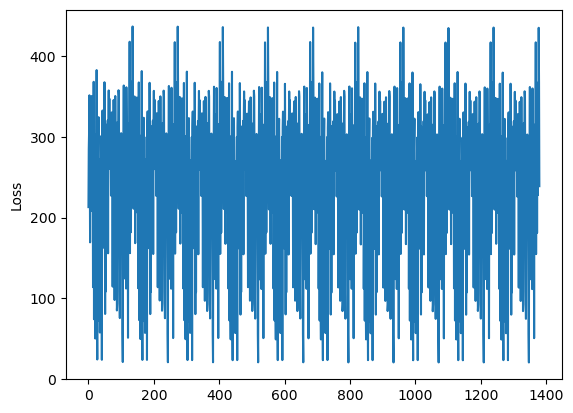

In [21]:
import matplotlib.pyplot as plt

plt.plot(loss_track)
plt.ylabel("Loss")

Text(0.5, 0, 'Epoch')

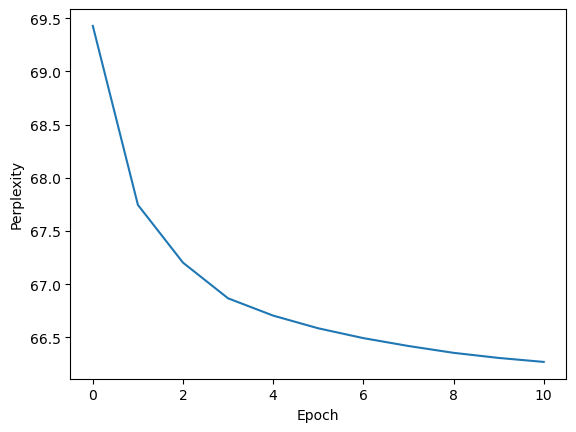

In [22]:
plt.plot(perplexity_track)
plt.ylabel("Perplexity")
plt.xlabel("Epoch")

## Generation

In [23]:
context = torch.load(f"Weights/genre_specific/lstm/{genre}/context.pth")
c0 = context["cell_state"].to(device)
h0 = context["h0_state"].to(device)
c0.shape, h0.shape

(torch.Size([2, 1, 1200]), torch.Size([2, 1, 1200]))

In [24]:
from modeling.model_utils import generate

gen_lyrics = generate(model, tokenizer, top_k = 10, max_new_tokens=50, debug = True, context_state=(c0, h0))
gen_lyrics["text"]

[('_I', 0.0614), ('_', 0.0574), ('You', 0.0334), ('I', 0.0213), ('_Hey', 0.0167), ('Hey', 0.0165), ('_You', 0.0159), ('The', 0.0151), ('_(', 0.0148), ('There', 0.0143)]
[('_am', 0.2201), ('_have', 0.0595), ('_do', 0.055), ('_was', 0.0495), ('_can', 0.0475), ('_will', 0.0409), ('_got', 0.0382), ('_know', 0.0271), ('_cannot', 0.0269), ('_want', 0.0251)]
[('_a', 0.3017), ('_to', 0.1586), ('_my', 0.0656), ('_the', 0.0593), ('_something', 0.0419), ('_some', 0.021), ('_your', 0.0184), ('_an', 0.0184), ('_this', 0.013), ('_you', 0.0116)]
[('_feeling', 0.0564), ('_blues', 0.0397), ('_news', 0.0192), ('_records', 0.0145), ('_best', 0.0133), ('_keys', 0.0133), ('_question', 0.0127), ('_money', 0.0121), ('_power', 0.0118), ('_devil', 0.0117)]
[(',', 0.2124), ('_I', 0.0752), ('_and', 0.061), ('_to', 0.0427), ('_on', 0.0363), ('_from', 0.0266), ('_(', 0.0263), ('_in', 0.0256), ('_you', 0.0202), ('_at', 0.018)]
[('_the', 0.3538), ('_my', 0.0768), ('_go', 0.0498), ('_get', 0.0256), ('_you', 0.0182), 

" I got the blues to keep my hands around I am going to let you see me down and down  Because the sun has not been so much more The day's gone, the road was all I have been here I go, yeah, yeah, I got the blues to keep my hands around I am going to let you see me down and down  Because the sun has not been so much more The day's gone, the road was all I have been here I go, yeah, yeah,"

In [25]:
generated_lyrics = [
    generate(model, tokenizer, top_k = 10, max_new_tokens=50, context_state=(c0, h0))["text"]
    for _ in range(50)
]

os.makedirs("Results/genre_specific/lstm/", exist_ok=True)
with open(f"Results/genre_specific/lstm/{genre}.json", "w") as f:
    json.dump(generated_lyrics, f)